The main objective of this notebook is to solve a binary image classification problem on publicly available Kaggle dataset 2013. We will try to reach state-of-the-art accuracy with less 10% data used in the competition with feature extraction and fine-tuning with a pretrained network.


## **The Data**
We can directly download the dataset from https://www.kaggle.com/competitions/dogs-vs-cats/data manually and then extract it in specified folader. However,, it is a good pratice to solve it using Kaggle API.

In [1]:
#Downloading the dataset

#Authenticating with Kaggle API
!mkdir .kaggle
!echo '{"username":"ayanbabusona","key":"faf532064a5895d0e95f400a2da88a68"}' > .kaggle/kaggle.json
!cat .kaggle/kaggle.json

#Run this to check that the Kaggle key is uploaded succesfully.
%ls /content/.kaggle/

#Get Kaggle competition list
%env KAGGLE_USERNAME= ayanbabusona
%env KAGGLE_KEY= faf532064a5895d0e95f400a2da88a68

#Get Kaggle competition files list
!kaggle competitions download -c dogs-vs-cats

{"username":"ayanbabusona","key":"faf532064a5895d0e95f400a2da88a68"}
kaggle.json
env: KAGGLE_USERNAME=ayanbabusona
env: KAGGLE_KEY=faf532064a5895d0e95f400a2da88a68
100% 809M/812M [00:15<00:00, 79.3MB/s]
100% 812M/812M [00:15<00:00, 54.3MB/s]


In [2]:
#checking the downloaded data
!ls
#extracting samples
!unzip dogs-vs-cats.zip
#extracting training ssamples
!unzip train.zip
#extracting testing samples
!unzip test1.zip

Streaming output truncated to the last 5000 lines.
  inflating: test1/5499.jpg          
  inflating: test1/55.jpg            
  inflating: test1/550.jpg           
  inflating: test1/5500.jpg          
  inflating: test1/5501.jpg          
  inflating: test1/5502.jpg          
  inflating: test1/5503.jpg          
  inflating: test1/5504.jpg          
  inflating: test1/5505.jpg          
  inflating: test1/5506.jpg          
  inflating: test1/5507.jpg          
  inflating: test1/5508.jpg          
  inflating: test1/5509.jpg          
  inflating: test1/551.jpg           
  inflating: test1/5510.jpg          
  inflating: test1/5511.jpg          
  inflating: test1/5512.jpg          
  inflating: test1/5513.jpg          
  inflating: test1/5514.jpg          
  inflating: test1/5515.jpg          
  inflating: test1/5516.jpg          
  inflating: test1/5517.jpg          
  inflating: test1/5518.jpg          
  inflating: test1/5519.jpg          
  inflating: test1/552.jpg           

In [3]:
#defining the small dataset to work on
import os,shutil
#original data directory
ori_train = '/content/train'
ori_test = '/content/test1'

#our dataset
base_dir ='/content/cat_vs_dog'
os.mkdir(base_dir)

#directories for the training validation and test splits
train_dir = os.path.join(base_dir, 'train')
os.mkdir(train_dir)
val_dir = os.path.join(base_dir, 'val')
os.mkdir(val_dir)
test_dir = os.path.join(base_dir, 'test')
os.mkdir(test_dir)

#Split every folder into cat and dog folder to separate the images
train_cat_dir = os.path.join(train_dir, 'cats')
os.mkdir(train_cat_dir)
train_dog_dir = os.path.join(train_dir, 'dogs')
os.mkdir(train_dog_dir)
val_cat_dir = os.path.join(val_dir, 'cats')
os.mkdir(val_cat_dir)
val_dog_dir = os.path.join(val_dir, 'dogs')
os.mkdir(val_dog_dir)
test_cat_dir = os.path.join(test_dir, 'cats')
os.mkdir(test_cat_dir)
test_dog_dir = os.path.join(test_dir, 'dogs')
os.mkdir(test_dog_dir)

#put the images in the respective folders
fnames = ['cat.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
  src = os.path.join(ori_train, fname)
  dst = os.path.join(train_cat_dir, fname)
  shutil.copy(src,dst)
fnames = ['dog.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
  src = os.path.join(ori_train, fname)
  dst = os.path.join(train_dog_dir, fname)
  shutil.copy(src,dst)
fnames = ['cat.{}.jpg'.format(i) for i in range(1000,1500)]
for fname in fnames:
  src = os.path.join(ori_train, fname)
  dst = os.path.join(val_cat_dir, fname)
  shutil.copy(src,dst)
fnames = ['dog.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
  src = os.path.join(ori_train, fname)
  dst = os.path.join(val_dog_dir, fname)
  shutil.copy(src,dst)
fnames = ['cat.{}.jpg'.format(i) for i in range(1500,2000)]
for fname in fnames:
  src = os.path.join(ori_train, fname)
  dst = os.path.join(test_cat_dir, fname)
  shutil.copy(src,dst)
fnames = ['dog.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
  src = os.path.join(ori_train, fname)
  dst = os.path.join(test_dog_dir, fname)
  shutil.copy(src,dst)

We all write a lot of code. So pat your back and tak a chill. Let's check whatever we did is correct or we made some mistakes

In [4]:
print("total training cat images: ", len(os.listdir(train_cat_dir)))
print("total training dog images: ", len(os.listdir(train_dog_dir)))
print("total validation cat images: ", len(os.listdir(val_cat_dir)))
print("total validation dog images: ", len(os.listdir(val_dog_dir)))
print("total test cat images: ", len(os.listdir(test_cat_dir)))
print("total test dog images: ", len(os.listdir(test_dog_dir)))

total training cat images:  1000
total training dog images:  1000
total validation cat images:  500
total validation dog images:  500
total test cat images:  500
total test dog images:  500


## **Buillding the network**
We are going to use 3 convolution layers followed by a maxpooling layer before flattening the tensor. We will start with a random image size 200, 200 and kernel size 3 x 3. All the hidden layers have ReLu activation and Output layer concluded with the sigmoid activation.

In [5]:
#Instantiating a small convnet for binary image classification
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(200,200,3)))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Conv2D(64, (3,3), activation='relu',))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Conv2D(128, (3,3), activation='relu',))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Conv2D(128, (3,3), activation='relu',))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 198, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 99, 99, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 48, 48, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 46, 46, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 23, 23, 128)      0

In [6]:
#Configuring the model for training
from tensorflow.keras import optimizers
model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=1e-4), metrics=['acc'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


## **Data Preprocessing**
The data should be formatted into appropiately preprocessed floating point tensors via following steps:


1.   Decode the JPEG contents to RGB grids of pixels.
2.   Convert these into floating-point tensors.
2.   Rescale the pixel values to the [0,1] interval.

Keras has module with image processing helper tools to perform all the above mentioned stuff.



In [7]:
from keras.preprocessing.image import ImageDataGenerator
#Rescales all images by 1/255
train_datagen = ImageDataGenerator(rescale=1./255)
train_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,  #target directory
    target_size = (200, 200),  #resize
    batch_size = 20,
    class_mode = 'binary'  #must be compatible with the loss function
)

val_generator = train_datagen.flow_from_directory(
    val_dir,  #target directory
    target_size = (200, 200),  #resize
    batch_size = 20,
    class_mode = 'binary'  #must be compatible with the loss function
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [8]:
#output of the generator
for data_batch, labels_batch in train_generator:
  print('data batch shape:', data_batch.shape)
  print('labels batch shape:', labels_batch.shape)
  break

data batch shape: (20, 200, 200, 3)
labels batch shape: (20,)


In [9]:
#Fitting the model using a batch generator
history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data = val_generator,
    validation_steps=50
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/30
100/100 [==============================] - 25s 110ms/step - loss: 0.6874 - acc: 0.5430 - val_loss: 0.6726 - val_acc: 0.5360
Epoch 2/30
100/100 [==============================] - 10s 101ms/step - loss: 0.6264 - acc: 0.6560 - val_loss: 0.6187 - val_acc: 0.6390
Epoch 3/30
100/100 [==============================] - 10s 100ms/step - loss: 0.5784 - acc: 0.6895 - val_loss: 0.6151 - val_acc: 0.6700
Epoch 4/30
100/100 [==============================] - 10s 101ms/step - loss: 0.5391 - acc: 0.7175 - val_loss: 0.5850 - val_acc: 0.6780
Epoch 5/30
100/100 [==============================] - 11s 115ms/step - loss: 0.4955 - acc: 0.7620 - val_loss: 0.5902 - val_acc: 0.6930
Epoch 6/30
100/100 [==============================] - 10s 102ms/step - loss: 0.4698 - acc: 0.7720 - val_loss: 0.5758 - val_acc: 0.6930
Epoch 7/30
100/100 [==============================] - 10s 101ms/step - loss: 0.4288 - acc: 0.8085 - val_loss: 0.6554 - val_acc: 0.6790
Epoch 8/30
100/100 [==============================] - 1

In [10]:
#saving the model
model.save('cats_vs_dogs_v1.h5')

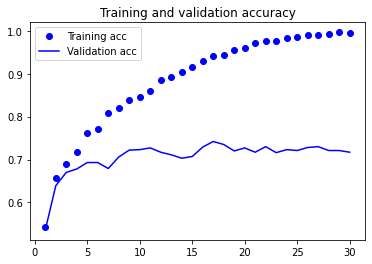

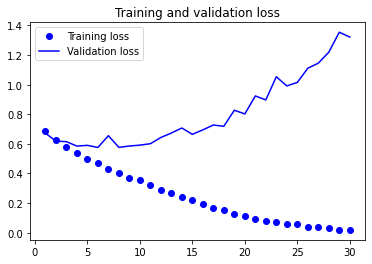

In [11]:
#displaying the curve of loss and accuracy during training
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()


## **Using Data Augmentation**
As we are working with very less amount of data, its prone to overfit the model. Increasing number of data point may help to get rid of it.

In [12]:
#A demo of data augmentation via ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=40, #(in degress 0-180)
    width_shift_range=0.2, #(as a fraction of total width within the images randomly translate vertically)
    height_shift_range=0.2, #(as a fraction of total height within the images randomly translate horizontally)
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

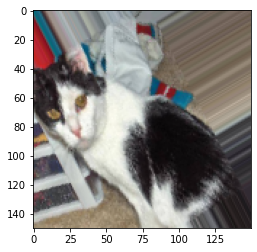

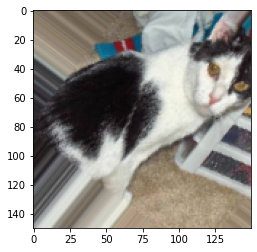

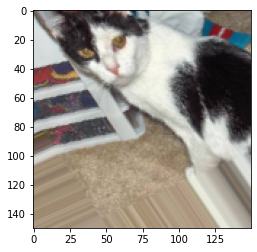

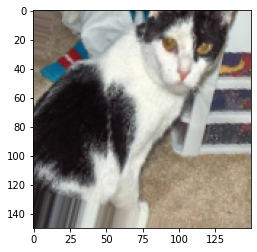

In [13]:
#Displaying some randomly augmented training images
from keras.preprocessing import image  #module with image preprocessing utilitites
fnames = [os.path.join(train_cat_dir, fname) for fname in os.listdir(train_cat_dir)]
img_path = fnames[3] #choses an image to augment
img = image.load_img(img_path, target_size=(150,150)) #Read the image and resize it.
x = image.img_to_array(img) #Converts it to a Numpy array with shape (150, 150, 3)
x = x.reshape((1,)+x.shape) #Reshape it to (1,150, 150, 3)
i=0
for batch in datagen.flow(x,batch_size=1):          #Generates batches of
  plt.figure(i)                                     #randomly transformed images.
  imgplot=plt.imshow(image.array_to_img(batch[0]))  #Loops indefinitely, so you need
  i+=1                                              # to break the loop
  if(i%4==0):                                       # at some point
    break
plt.show()

## **Introducing Dropouts**
Though the number of images increased, they are still heavily intercorelated, due to generation from small number of sample images (i.e. no new information). So it can't completely help to get rid of overfitting which motivate to introduce dropout layers in our network.

In [37]:
#Defining the convnet with dropout
model = models.Sequential()
model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(200,200,3)))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Conv2D(64, (3,3), activation='relu',))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Conv2D(128, (3,3), activation='relu',))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Conv2D(128, (3,3), activation='relu',))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 198, 198, 32)      896       
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 99, 99, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 97, 97, 64)        18496     
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 48, 48, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 46, 46, 128)       73856     
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 23, 23, 128)     

In [38]:
model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=1e-4), metrics=['acc'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [39]:
#data augmentation generators
train_datagen = ImageDataGenerator (
    rescale=1./255,
    rotation_range=40, 
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255) #Note that validation data shouldn't be augmented.

In [40]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(200,200),
    batch_size=32,
    class_mode='binary'
)

val_generator = train_datagen.flow_from_directory(
    val_dir,
    target_size=(200,200),
    batch_size=32,
    class_mode='binary'
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [41]:
#Now let's see the model performance improved or not
history=model.fit_generator (
    train_generator,
    steps_per_epoch=10,
    epochs=50,
    validation_data=val_generator,
    validation_steps=20
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/50
10/10 [==============================] - 11s 1s/step - loss: 0.7011 - acc: 0.5362 - val_loss: 0.7083 - val_acc: 0.4984
Epoch 2/50
10/10 [==============================] - 10s 1s/step - loss: 0.6950 - acc: 0.5031 - val_loss: 0.6881 - val_acc: 0.5234
Epoch 3/50
10/10 [==============================] - 10s 1s/step - loss: 0.6860 - acc: 0.5625 - val_loss: 0.7133 - val_acc: 0.4781
Epoch 4/50
10/10 [==============================] - 10s 1s/step - loss: 0.6904 - acc: 0.5594 - val_loss: 0.7061 - val_acc: 0.5281
Epoch 5/50
10/10 [==============================] - 10s 1s/step - loss: 0.7025 - acc: 0.4836 - val_loss: 0.6943 - val_acc: 0.5031
Epoch 6/50
10/10 [==============================] - 10s 1s/step - loss: 0.6896 - acc: 0.5469 - val_loss: 0.7067 - val_acc: 0.4875
Epoch 7/50
10/10 [==============================] - 10s 1s/step - loss: 0.6957 - acc: 0.5033 - val_loss: 0.6849 - val_acc: 0.5391
Epoch 8/50
10/10 [==============================] - 10s 1s/step - loss: 0.6856 - acc: 0.57

In [42]:
#saving the model
model.save('cats_vs_dogs_v2.h5')

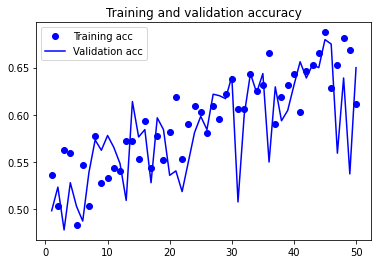

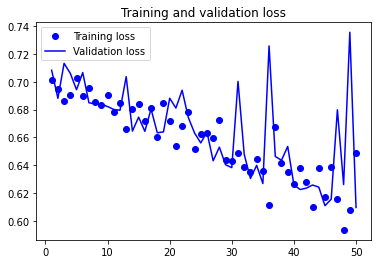

In [43]:
#displaying the curve of loss and accuracy during training
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

Here, the training and validation accuracy has been decreased but the overfitting issues has been quite resolved.

## **Using a Pretrained Convnet**
Here, we are going to use the VGG16 network trained on Imagenet dataset to classify this task. This techniques involved twoe steps.


1.   ***Feature Extraction:*** Train the convolutional base only and extract the features and then classify it through single Dense Layers. It is a cost effective techniques which doesn't support data augmentation appraoch.
2.   ***Fine-Tunning:*** Train the entire model in end-to-end manner on the new dataset.



### **Feature Extraction**

In [46]:
#Instantiating VGG16 convolutional base
from keras.applications.vgg16 import VGG16
conv_base = VGG16(
    weights='imagenet', #the weight checkpoint to initialize the model
    include_top=False,  #True = End-to-End; False=Convolutional base
    input_shape=(200,200,3) #Optional
)

58900480/58889256 [==============================] - 1s 0us/step


In [47]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 200, 200, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 200, 200, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 100, 100, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 100, 100, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 100, 100, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 50, 50, 128)       0     

In [51]:
#Extracting features using the pretrained convolutional base
import numpy as np
datagen = ImageDataGenerator(rescale=1./255)
batch_size=20

def extract_features (directory, sample_count):
  features = np.zeros(shape=(sample_count, 6, 6, 512))
  labels = np.zeros(shape=(sample_count))
  generator = datagen.flow_from_directory (
      directory,
      target_size=(200,200),
      batch_size=batch_size,
      class_mode='binary'
  )
  i=0
  for inputs_batch, labels_batch in generator:
    features_batch = conv_base.predict(inputs_batch)
    features[i*batch_size:(i+1)*batch_size]=features_batch
    labels[i*batch_size:(i+1)*batch_size]=labels_batch
    i+=1
    if(i*batch_size>=sample_count):
      break
  return features,labels

train_features, train_labels = extract_features(train_dir,2000)
val_features, val_labels = extract_features(val_dir,1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [54]:
#Defining and training the densely connected classifier
model = models.Sequential()
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu', input_dim=6*6*512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=2e-5), metrics=['acc'])

history = model.fit(train_features,train_labels,epochs=30,batch_size=20,validation_data=(val_features,val_labels))

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Epoch 1/30
100/100 [==============================] - 1s 9ms/step - loss: 0.5026 - acc: 0.7475 - val_loss: 0.3381 - val_acc: 0.8840
Epoch 2/30
100/100 [==============================] - 1s 8ms/step - loss: 0.3150 - acc: 0.8735 - val_loss: 0.2721 - val_acc: 0.9000
Epoch 3/30
100/100 [==============================] - 1s 8ms/step - loss: 0.2458 - acc: 0.8985 - val_loss: 0.2459 - val_acc: 0.9110
Epoch 4/30
100/100 [==============================] - 1s 7ms/step - loss: 0.2112 - acc: 0.9165 - val_loss: 0.2332 - val_acc: 0.9140
Epoch 5/30
100/100 [==============================] - 1s 10ms/step - loss: 0.1920 - acc: 0.9265 - val_loss: 0.2334 - val_acc: 0.9030
Epoch 6/30
100/100 [==============================] - 1s 10ms/step - loss: 0.1545 - acc: 0.9410 - val_loss: 0.2245 - val_acc: 0.9080
Epoch 7/30
100/100 [==============================] - 1s 10ms/step - loss: 0.1474 - acc: 0.9435 - val_loss: 0.2129 - val_acc: 0.9110
Epoch 8/30
100/100 [==============================] - 1s 9ms/step - loss:

In [55]:
#saving the model
model.save('cats_vs_dogs_v3.h5')

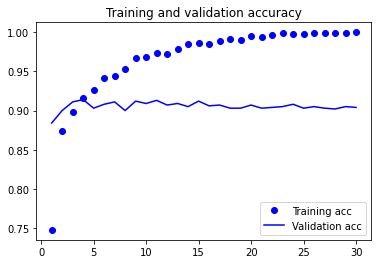

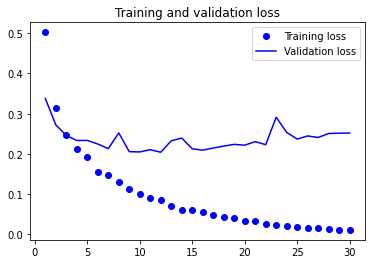

In [56]:
#displaying the curve of loss and accuracy during training
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

In [57]:
#End-to-End
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 6, 6, 512)         14714688  
                                                                 
 flatten_7 (Flatten)         (None, 18432)             0         
                                                                 
 dense_16 (Dense)            (None, 256)               4718848   
                                                                 
 dense_17 (Dense)            (None, 1)                 257       
                                                                 
Total params: 19,433,793
Trainable params: 19,433,793
Non-trainable params: 0
_________________________________________________________________




> Note: for the End-to-End we must frozen the convolutional base for otherwise the dense layer will randomly initialized and destroy the previous learning of the convolutional base.



In [58]:
print("the trainable layers before freezing: ", len(model.trainable_weights))
conv_base.trainable=False
print("after_freezing: ", len(model.trainable_weights))

the trainable layers before freezing:  30
after_freezing:  4


In [61]:
model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=2e-5), metrics=['acc'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [66]:
history=model.fit_generator(
    train_generator,
    steps_per_epoch=50,
    epochs=30,
    validation_data=val_generator,
    validation_steps=10
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/30
50/50 [==============================] - 23s 453ms/step - loss: 0.3456 - acc: 0.8510 - val_loss: 0.3703 - val_acc: 0.8406
Epoch 2/30
50/50 [==============================] - 22s 443ms/step - loss: 0.3499 - acc: 0.8428 - val_loss: 0.3428 - val_acc: 0.8687
Epoch 3/30
50/50 [==============================] - 22s 446ms/step - loss: 0.3344 - acc: 0.8510 - val_loss: 0.2718 - val_acc: 0.9000
Epoch 4/30
50/50 [==============================] - 22s 448ms/step - loss: 0.3051 - acc: 0.8687 - val_loss: 0.3228 - val_acc: 0.8562
Epoch 5/30
50/50 [==============================] - 22s 442ms/step - loss: 0.3293 - acc: 0.8535 - val_loss: 0.3318 - val_acc: 0.8562
Epoch 6/30
50/50 [==============================] - 22s 446ms/step - loss: 0.2944 - acc: 0.8737 - val_loss: 0.3174 - val_acc: 0.8813
Epoch 7/30
50/50 [==============================] - 22s 441ms/step - loss: 0.3052 - acc: 0.8542 - val_loss: 0.3264 - val_acc: 0.8813
Epoch 8/30
50/50 [==============================] - 22s 440ms/step - 

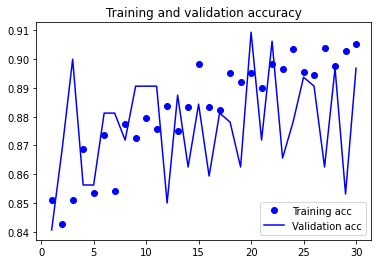

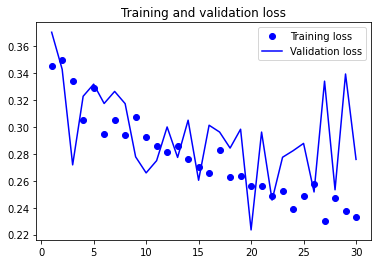

In [67]:
#displaying the curve of loss and accuracy during training
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

In [68]:
#saving the model
model.save('cats_vs_dogs_v4.h5')

## **Fine-tuning**
Here we unfreezed the top layers of a frozen model base and jointly training with the classifier.

In [69]:
#Freezing all layers up to a specific one
conv_base.trainable=True

set_trainable=False
for layer in conv_base.layers:
  if(layer.name == 'block5_conv1'):
    set_trainable = True
  if(set_trainable):
    layer.trainable=True
  else:
    layer.trainable=False

In [70]:
model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=2e-5), metrics=['acc'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [71]:
history=model.fit_generator(
    train_generator,
    steps_per_epoch=50,
    epochs=30,
    validation_data=val_generator,
    validation_steps=10
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/30
50/50 [==============================] - 26s 492ms/step - loss: 0.3349 - acc: 0.8630 - val_loss: 0.2624 - val_acc: 0.8969
Epoch 2/30
50/50 [==============================] - 23s 455ms/step - loss: 0.2361 - acc: 0.9050 - val_loss: 0.5982 - val_acc: 0.7750
Epoch 3/30
50/50 [==============================] - 23s 451ms/step - loss: 0.2073 - acc: 0.9091 - val_loss: 0.1902 - val_acc: 0.9281
Epoch 4/30
50/50 [==============================] - 23s 452ms/step - loss: 0.1751 - acc: 0.9250 - val_loss: 0.1956 - val_acc: 0.9031
Epoch 5/30
50/50 [==============================] - 23s 457ms/step - loss: 0.1703 - acc: 0.9319 - val_loss: 0.2258 - val_acc: 0.9000
Epoch 6/30
50/50 [==============================] - 23s 460ms/step - loss: 0.1737 - acc: 0.9299 - val_loss: 0.2013 - val_acc: 0.9125
Epoch 7/30
50/50 [==============================] - 22s 449ms/step - loss: 0.1402 - acc: 0.9426 - val_loss: 0.2066 - val_acc: 0.9094
Epoch 8/30
50/50 [==============================] - 22s 448ms/step - 

In [73]:
#saving the model
model.save('cats_vs_dogs_v5.h5')

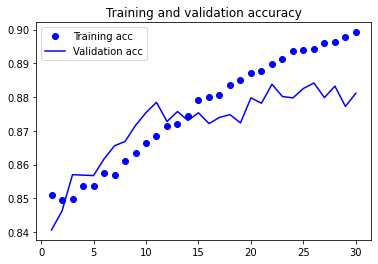

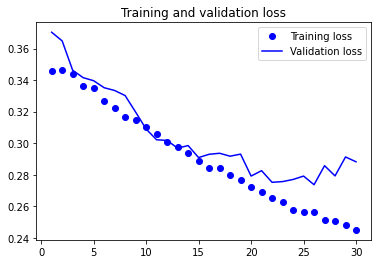

In [72]:
#smoothing the plots
def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if(smoothed_points):
      previous = smoothed_points[-1]
      smoothed_points.append(previous*factor + point*(1-factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

plt.plot(epochs, smooth_curve(acc), 'bo', label='Training acc')
plt.plot(epochs, smooth_curve(val_acc), 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, smooth_curve(loss), 'bo', label='Training loss')
plt.plot(epochs, smooth_curve(val_loss), 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()